In [1]:
import pickle
import pandas as pd
from json2html import *
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
from IPython.core.display import display, HTML
from hs_gimme.application_status_history_classifier.machine_learning_status_classifier import get_machine_learning_status_classifier
from hs_gimme.account_settings_manager import get_account_settings
from collections import Counter
from hs_gimme.application_status_history_classifier.new_cls import NewStatusCls

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_78901/3987049292.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Tagged Data

In [2]:
tagged_df = pd.read_pickle('tagging_analysis_df.pkl')

In [3]:
mongos = {}
account_settings = {}
status_cls = {}
new_cls = {}
prod_mongos = {}
for account_id in tagged_df['account_id'].unique():
    print(account_id)
    mongos[account_id] = get_mongo_client_db('production_qa', account_id)
    prod_mongos[account_id] = get_mongo_client_db('production', account_id)
    account_settings[account_id] =  get_account_settings(account_id)
    status_cls[account_id] = get_machine_learning_status_classifier('production', account_id)
    new_cls[account_id] = NewStatusCls(account_id, 'production')

alabama
2023-10-09T09:18:29.512191Z [info     ] Mongos instances selected      environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/db_facade/connection_string_builder.py function_name=get_selected_mongos_instances hostname=Dima-Shulga-MacBook-Pro hosts=['applicativedb-prod-mongos-1.omcomcom.com', 'applicativedb-prod-mongos-2.omcomcom.com'] line_number=38 module=hs_gimme.db_facade.connection_string_builder pid=78901
2023-10-09T09:19:08.976348Z [warning  ] SlowLog                        command_name=getMore connection_id=applicativedb-prod-mongos-1.omcomcom.com:27017 duration_ms__numeric=38072.751 duration_threshold__numeric=10000 environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/db_facade/slow_logs_utils.py function_name=write_slow_log hostname=Dima-Shulga-MacBook-Pro line_number=11 module=hs_gimme.db_facade.slow_logs_utils pid=78901 request_id=1404280278 source=PyMongo stack_snippet=
  File "/Users/dima/hiredscore/gimme/hs_gimme/application_status_history_

In [4]:
tagged_df['new_max_status'] = tagged_df.apply(lambda r: new_cls[r['account_id']].get_max_status(r['app']), axis=1)
tagged_df['new_max_status'].value_counts()

 0    160
-1    113
 4     49
 3     40
 1     27
 2      3
Name: new_max_status, dtype: int64

In [5]:
tagged_df['max_status'] = tagged_df.apply(lambda r: status_cls[r['account_id']].get_max_status(r['app']), axis=1)
tagged_df['max_status'].value_counts()

 0    160
-1     84
 4     68
 3     50
 1     27
 2      3
Name: max_status, dtype: int64

In [6]:
def get_new_group(new_max_status):
    if new_max_status == 0:
        return 'rejected'
    
    if new_max_status >= 3: 
        return 'offer'
    
    return 'other'

In [7]:
tagged_df['group_name'] = tagged_df['group_name'].apply(lambda x: 'rejected' if x == 'Negative Rejected' else 'offer')

In [8]:
tagged_df['group_name'] = tagged_df['max_status'].apply(get_new_group)

In [9]:
tagged_df['new_group_name'] = tagged_df['new_max_status'].apply(get_new_group)

In [10]:
old_gb = tagged_df.groupby(['group_name'])['is_good'].agg(['count', 'mean'])
old_gb['mapping'] = 'current'


new_gb = tagged_df[lambda x: x['new_group_name'] != 'other'].groupby(['new_group_name'])['is_good'].agg(['count', 'mean'])
new_gb['mapping'] = 'new'


gb = pd.concat([old_gb, new_gb]).set_index('mapping', append=True).unstack()
gb

count             mean          
mapping  current    new   current       new
offer      118.0   89.0  0.779661  0.831461
other      114.0    NaN  0.701754       NaN
rejected   160.0  160.0  0.512500  0.512500

<Axes: >

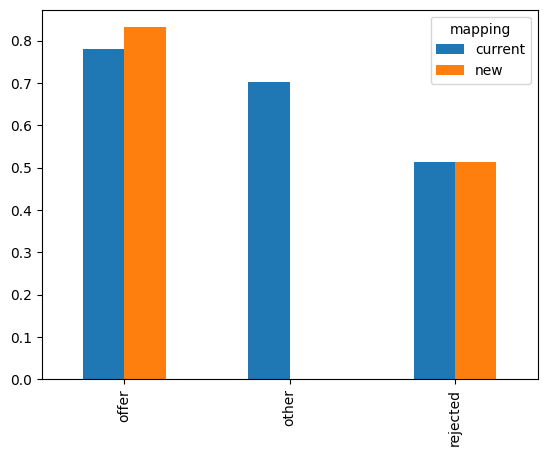

In [11]:
gb['mean'].plot(kind='bar')

# Accounts Data

In [12]:
accounts_data = pickle.load(open('statuses_acounts_data.pkl', 'rb'))
len(accounts_data)

45000

In [13]:
accounts_df = pd.DataFrame(accounts_data)

In [14]:
for account_id in accounts_df['account'].unique():
    if account_id not in mongos:
        print(account_id)
        mongos[account_id] = get_mongo_client_db('production_qa', account_id)
        prod_mongos[account_id] = get_mongo_client_db('production', account_id)
        account_settings[account_id] =  get_account_settings(account_id)
        status_cls[account_id] = get_machine_learning_status_classifier('production', account_id)
        new_cls[account_id] = NewStatusCls(account_id, 'production')

seattle
2023-10-09T09:21:29.348876Z [warning  ] ats_integration_type is deprecated. Please stop using ats_integration_type in your code environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/account_settings/account_settings_object.py function_name=_get_ats_name hostname=Dima-Shulga-MacBook-Pro line_number=61 module=hs_gimme.account_settings.account_settings_object pid=78901
zagreb
2023-10-09T09:21:30.878480Z [warning  ] ats_integration_type is deprecated. Please stop using ats_integration_type in your code environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/account_settings/account_settings_object.py function_name=_get_ats_name hostname=Dima-Shulga-MacBook-Pro line_number=61 module=hs_gimme.account_settings.account_settings_object pid=78901
antwerp
2023-10-09T09:21:32.462466Z [warning  ] ats_integration_type is deprecated. Please stop using ats_integration_type in your code environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/account_settings/acco

In [15]:
accounts_df['new_max_status'] = accounts_df.apply(lambda r: new_cls[r['account']].get_max_status(r['app']), axis=1)
accounts_df['new_max_status'].value_counts()

 0    26784
-1    10917
 2     3025
 1     2710
 4      953
 3      611
Name: new_max_status, dtype: int64

In [16]:
accounts_df['max_status'] = accounts_df.apply(lambda r: status_cls[r['account']].get_max_status(r['app']), axis=1)
accounts_df['max_status'].value_counts()

 0    26244
-1     9280
 2     4697
 1     2710
 4     1193
 3      876
Name: max_status, dtype: int64

<Axes: xlabel='account'>

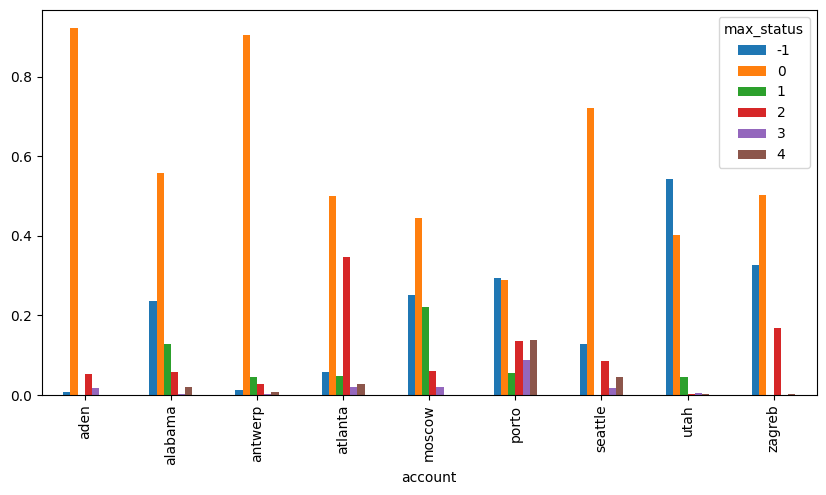

In [17]:
(accounts_df.groupby(['account', 'max_status']).size() / accounts_df.groupby(['account']).size()).unstack(1).plot(kind='bar', figsize=(10, 5))

<Axes: xlabel='account'>

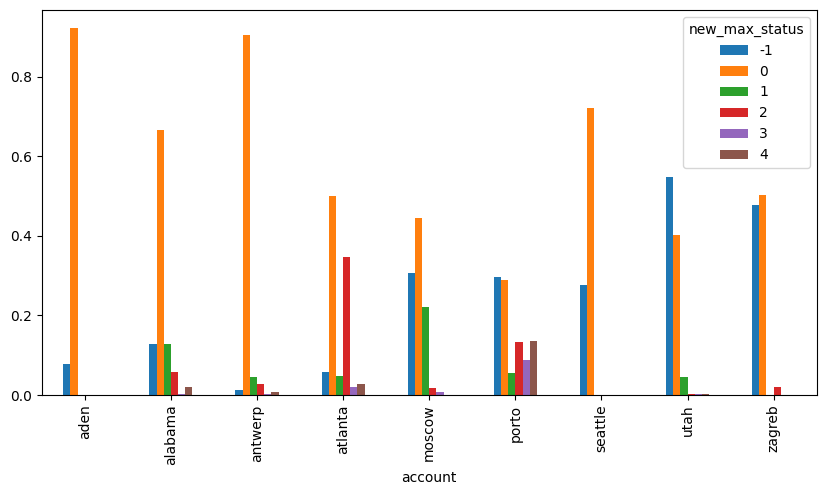

In [18]:
(accounts_df.groupby(['account', 'new_max_status']).size() / accounts_df.groupby(['account']).size()).unstack(1).plot(kind='bar', figsize=(10, 5))

<Axes: xlabel='max_status'>

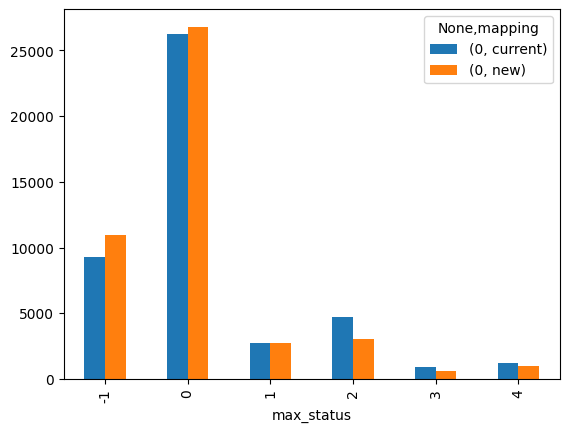

In [19]:
old_gb = accounts_df.groupby('max_status').size().reset_index()
old_gb['mapping'] = 'current'

new_gb = accounts_df.groupby('new_max_status').size().reset_index().rename(columns={'new_max_status': 'max_status'})
new_gb['mapping'] = 'new'

gb = pd.concat([old_gb, new_gb]).set_index(['max_status', 'mapping'])
gb.unstack().plot(kind='bar')

In [20]:
gb.unstack()

0       
mapping    current    new
max_status               
-1            9280  10917
 0           26244  26784
 1            2710   2710
 2            4697   3025
 3             876    611
 4            1193    953

In [21]:
old_gb = accounts_df.groupby('max_status').size().reset_index()

In [22]:
old_gb

,max_status,0
0,-1,9280
1,0,26244
2,1,2710
3,2,4697
4,3,876
5,4,1193


In [23]:
accounts_df['is_different'] = accounts_df['max_status'] != accounts_df['new_max_status']
accounts_df['is_different'].mean()

0.06037777777777778

<Axes: xlabel='account'>

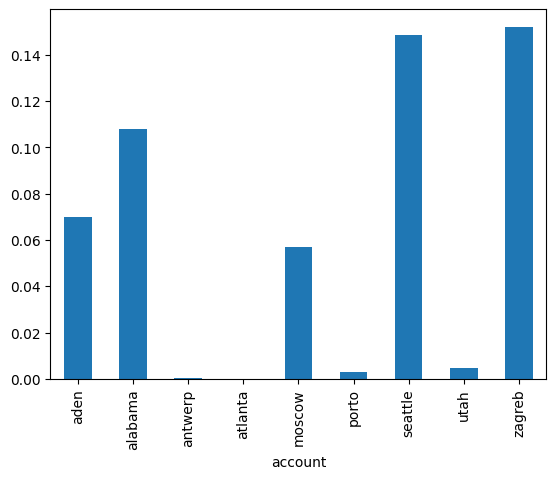

In [24]:
accounts_df.groupby('account')['is_different'].mean().plot(kind='bar')

<Axes: xlabel='account'>

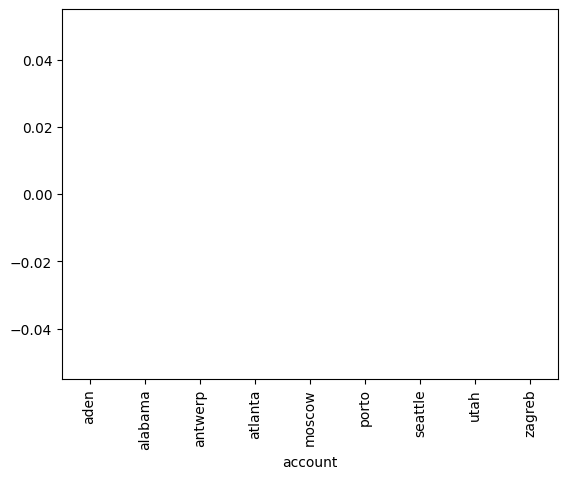

In [25]:
accounts_df[(accounts_df['max_status'] != -1) & (accounts_df['new_max_status'] != -1)].groupby('account')['is_different'].mean().plot(kind='bar')

In [27]:
' '.join(accounts_df['account'].unique())

'seattle zagreb antwerp atlanta aden alabama utah moscow porto'